Purpose of this file:

This file contains everything related to the experiment I am trying to perform.

Also below is just me exploring the transformer_lens library and understanding the workings of the library.

In [2]:
import torch
import transformer_lens
import circuitsvis as cv
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

/home/ec2-user/mechanistic-interpretability/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = utils.get_device()
print(f"Using device: {device}")

Using device: cuda


In [3]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
model_description_text = """## Loading Models

HookedTransformer comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. See my explainer for documentation of all supported models, and this table for hyper-parameters and the name used to load them. Each model is loaded into the consistent HookedTransformer architecture, designed to be clean, consistent and interpretability-friendly. 

For this demo notebook we'll look at GPT-2 Small, an 80M parameter model. To try the model the model out, let's find the loss on this paragraph!"""
loss = model(model_description_text, return_type="loss")
print("Model loss:", loss)

Model loss: tensor(4.1758, device='cuda:0', grad_fn=<DivBackward0>)


In [5]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text)
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

cuda:0


In [6]:
for cache in gpt2_cache:
    print(cache)

hook_embed
hook_pos_embed
blocks.0.hook_resid_pre
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn.hook_q
blocks.0.attn.hook_k
blocks.0.attn.hook_v
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_z
blocks.0.hook_attn_out
blocks.0.hook_resid_mid
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_mlp_out
blocks.0.hook_resid_post
blocks.1.hook_resid_pre
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.attn.hook_q
blocks.1.attn.hook_k
blocks.1.attn.hook_v
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_z
blocks.1.hook_attn_out
blocks.1.hook_resid_mid
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.mlp.hook_pre
blocks.1.mlp.hook_post
blocks.1.hook_mlp_out
blocks.1.hook_resid_post
blocks.2.hook_resid_pre
blocks.2.ln1.hook_scale
blocks.2.ln1.hook_normalized
blocks.2.attn.hook_q
blocks.2.attn.hook_k
blocks.2.attn.hook_v
blocks.2.att

From this we can see that the gpt2 model has 12 layers, 12 heads.

We can use this information to get the attention pattern for any layer and head

In [7]:
print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0, "attn"]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(gpt2_text)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 33, 33])


visualization:
- The heads focusing strongly on the current tokens have a sharp diagonal pattern.
- Other attend to local context (fuzzy diagonal).
- A few heads show patterns of attending to related tokens nearby.

In [8]:
print("Layer 5 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

Layer 5 Head Attention Patterns:


Layer 0 seems to be primarily focused on local relationships between tokens, as seen by the predominantly diagonal patters. This makes sense as it's the first layer of the network, typically handling lower-level patterns.

### Now onto my own thing

Features as Neurons


Here's I think we can do it:
- Hook into the forward pass at each neuron (or layer you're interested in).
- Record activations for a batch of inputs with known feature labels (e.g., class label, specific feature presence).
- For each neuron, compute how its activation strength correlates with each feature.
- Systematically vary the feature inputs and see which neurons activaions changes the most.


In [3]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tqdm import tqdm

In [4]:
# loading the model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
model.eval()

Using device: cuda


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [5]:
dataset = load_dataset("glue", "sst2", split="train[:50%]")
print(f"Dataset size: {len(dataset)}")

Dataset size: 33674


In [6]:
# Collate function to force max_length padding
def collate_fn(batch):
    texts = [x["sentence"] for x in batch]
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=64  # fix length
    )
    return inputs

# DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [7]:
# Hooking into the model
activations = []

def hook_fn(module, input, output):
    # output shape: (batch_size, sequence_length, hidden_dim)
    activations.append(output.detach().cuda())

# choosing the MLP block here
hook_handle = model.h[5].mlp.register_forward_hook(hook_fn)

In [8]:
# Tokenize the dataset and run through the model
tokenizer.pad_token = tokenizer.eos_token  # Set pad token
all_labels = []

print("Processing batches...")
with torch.no_grad():
    for batch_idx, inputs in enumerate(tqdm(dataloader)):
        # Get labels
        batch_labels = dataset[batch_idx * dataloader.batch_size : (batch_idx + 1) * dataloader.batch_size]["label"]
        all_labels.extend(batch_labels)
        
        # Move inputs to device
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)


Processing batches...


100%|██████████| 16837/16837 [02:38<00:00, 106.11it/s]


In [9]:
# Processing activations

# stacking the activations
activations = torch.cat(activations, dim=0) # (n_samples, seq_len, hidden_dim)
all_labels = torch.tensor(all_labels).to(device)

# get mean activations per sequence
mean_activations = activations.mean(dim=1) # (n_sample, hidden_dim)

In [10]:
# correlation analysis
mean_activations_cpu = mean_activations.cpu().numpy()
labels_cpu = all_labels.cpu().numpy()

# computing corelation for each neuron
correlations = []
p_values = []

for neuron_idx in range(mean_activations_cpu.shape[1]):
    corr, p_value = pearsonr(mean_activations_cpu[:, neuron_idx], labels_cpu)
    correlations.append(corr)
    p_values.append(p_value)

# converting to numpy arrays
correlations = np.array(correlations)
p_values = np.array(p_values)

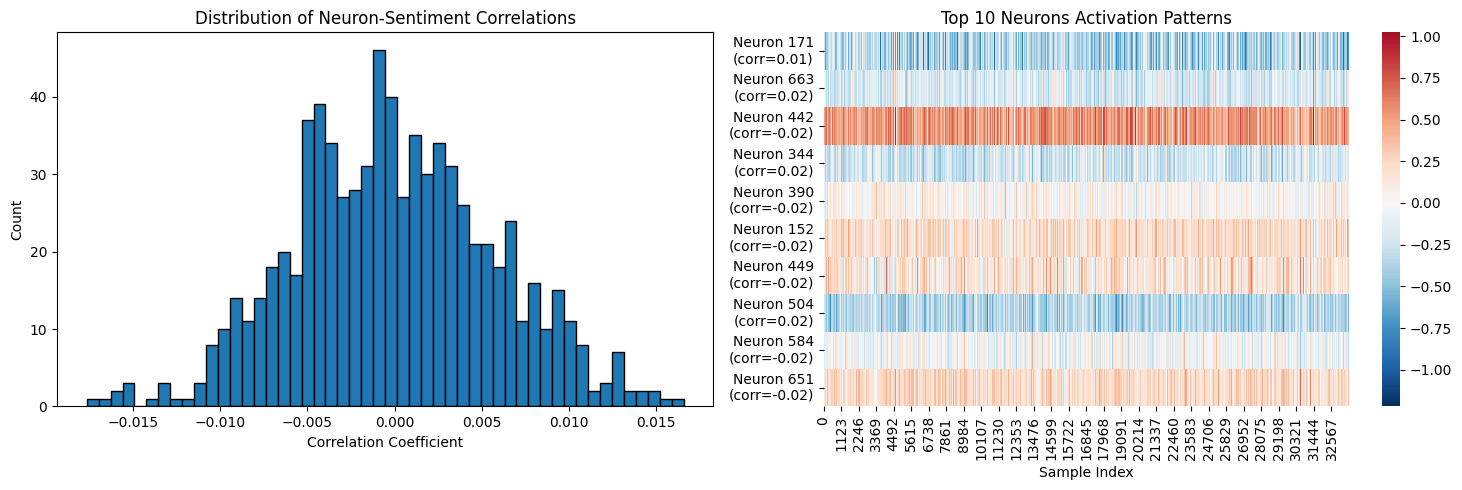

In [11]:
# visualize
plt.figure(figsize=(15, 5))

# correlation distribution
plt.subplot(1, 2, 1)
plt.hist(correlations, bins=50, edgecolor='black')
plt.title('Distribution of Neuron-Sentiment Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')

# top 10 neurons by absolute correlation
top_neuron_indices = np.argsort(np.abs(correlations))[-10:]
top_correlations = correlations[top_neuron_indices]

plt.subplot(1, 2, 2)
sns.heatmap(
    mean_activations_cpu[:, top_neuron_indices].T,
    cmap='RdBu_r',
    center=0,
    yticklabels=[f'Neuron {i}\n(corr={c:.2f})' for i, c in zip(top_neuron_indices, top_correlations)]
)
plt.title('Top 10 Neurons Activation Patterns')
plt.xlabel('Sample Index')

plt.tight_layout()
plt.show()

In [13]:
# Print some statistics
print("\n\tAnalysis Results:")
print(f"Number of neurons analyzed: {len(correlations)}")
print(f"Strongest positive correlation: {np.max(correlations):.3f}")
print(f"Strongest negative correlation: {np.min(correlations):.3f}")
print(f"Mean absolute correlation: {np.mean(np.abs(correlations)):.3f}")

# Clean up
hook_handle.remove()  # Remove the hook


	Analysis Results:
Number of neurons analyzed: 768
Strongest positive correlation: 0.017
Strongest negative correlation: -0.018
Mean absolute correlation: 0.005


### Testing with a random input sentence


Analyzing sentence: 'This movie is absolutely fantastic and I loved every minute of it!'

Top 10 most activated neurons:
--------------------------------------------------
Rank 1: Neuron  447 | Activation:   12.434
Rank 2: Neuron  481 | Activation:    2.568
Rank 3: Neuron  762 | Activation:    0.868
Rank 4: Neuron  674 | Activation:    0.808
Rank 5: Neuron  102 | Activation:    0.685
Rank 6: Neuron  692 | Activation:    0.681
Rank 7: Neuron  378 | Activation:    0.664
Rank 8: Neuron    3 | Activation:    0.641
Rank 9: Neuron  388 | Activation:    0.624
Rank 10: Neuron  255 | Activation:    0.623


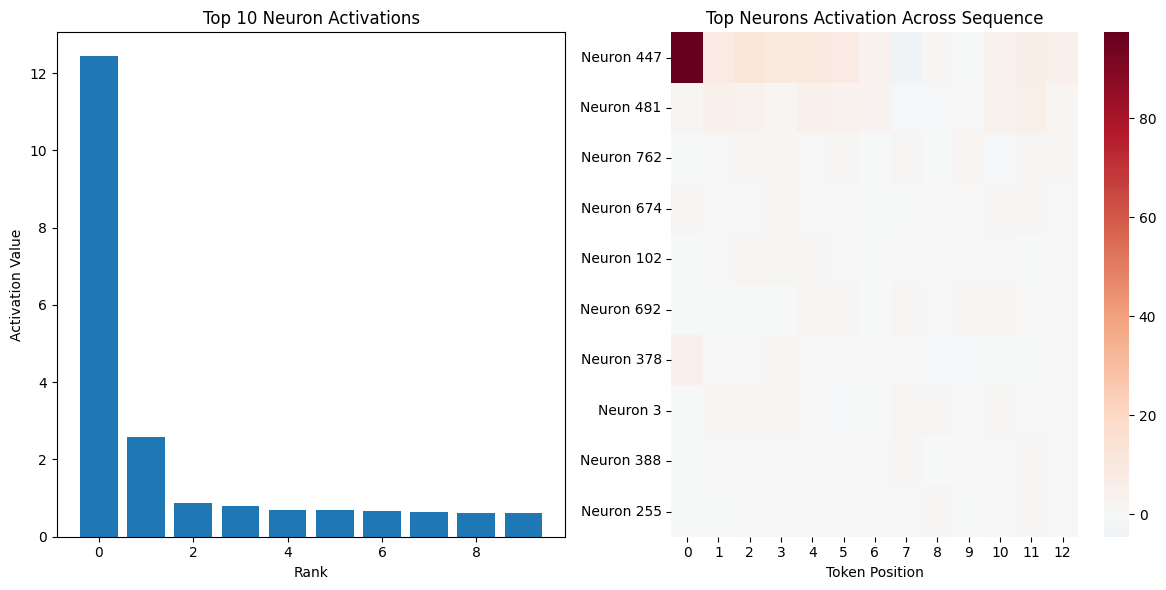


Token-by-token analysis:
--------------------------------------------------
Tokens: This Ġmovie Ġis Ġabsolutely Ġfantastic Ġand ĠI Ġloved Ġevery Ġminute Ġof Ġit !


In [ ]:
# clear any existing hooks
for hook in list(model.h[5].mlp._forward_hooks.values()):
    hook.remove()

activations = []

# rgister the hook
def hook_fn(module, input, output):
    # output shape: (batch_size, sequence_length, hidden_dim)
    activations.append(output.detach().cpu()) 

hook_handle = model.h[5].mlp.register_forward_hook(hook_fn)

test_sentence = "This movie is absolutely fantastic and I loved every minute of it!"

# tokenize
tokenizer.pad_token = tokenizer.eos_token  # ensure pad token is set
inputs = tokenizer(
    test_sentence,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=64
)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# run through model
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# get the collected activation (should be just one tensor now)
activation = activations[0]  # shape: (1, seq_len, hidden_dim)

# get the actual sequence length (non-padding tokens)
seq_len = attention_mask.sum().item()

# get mean activation across sequence length (excluding padding)
mean_activation = activation[0, :seq_len, :].mean(dim=0)  # shape: (hidden_dim,)

# top K neurons
K = 10  # umber of top neurons to show
top_k_values, top_k_indices = torch.topk(mean_activation, K)


print(f"\nAnalyzing sentence: '{test_sentence}'\n")
print("Top 10 most activated neurons:")
print("-" * 50)
for i, (idx, val) in enumerate(zip(top_k_indices.cpu().numpy(), top_k_values.cpu().numpy())):
    print(f"Rank {i+1}: Neuron {idx:4d} | Activation: {val:8.3f}")

# Visualize
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(K), top_k_values.cpu().numpy())
plt.title('Top 10 Neuron Activations')
plt.xlabel('Rank')
plt.ylabel('Activation Value')

# activation pattern across sequence
plt.subplot(1, 2, 2)
sequence_activations = activation[0, :seq_len, top_k_indices].cpu().numpy().T
sns.heatmap(
    sequence_activations,
    cmap='RdBu_r',
    center=0,
    yticklabels=[f'Neuron {i}' for i in top_k_indices.cpu().numpy()]
)
plt.title('Top Neurons Activation Across Sequence')
plt.xlabel('Token Position')

plt.tight_layout()
plt.show()

# print the tokens for reference
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])[:seq_len]
print("\nToken-by-token analysis:")
print("-" * 50)
print("Tokens:", " ".join(tokens))

From the above thing we can see that neuron 447 is the most activated neuron for the sentence, which is followed by neuron 481.

Why is it activated the most?
Well that's the point of mechanistic interpretability, we want to find out why a neuron is activated the most. But according to me that can be because of when the model was trained, this neuron captured some pattern which is also found in the test sentence.

And also we can see that it's not just one neuron, but a combination of neurons that are activated, this means that neurons are not monosemantic in nature, but rather polysemantic. Also a layer of neuron can contain both monosemantic and polysemantic neurons.